<a href="https://colab.research.google.com/github/eileenblum/Lyric-Generator/blob/main/Lyric_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


References:
*   Arjovsky, M., Chintala, S., & Bottou, L. (2017). Wasserstein generative adversarial networks. In International conference on machine learning (pp. 214-223). PMLR.
*   Donahue, D., & Rumshisky, A. (2018). Adversarial text generation without reinforcement learning. arXiv preprint arXiv:1810.06640.
* Gulrajani, I., Ahmed, F., Arjovsky, M., Dumoulin, V., & Courville, A. (2017). Improved training of wasserstein gans. arXiv preprint arXiv:1704.00028.
*   Haidar, M., Rezagholizadeh, M., Do-Omri, A., & Rashid, A. (2019). Latent code and text-based generative adversarial networks for soft-text generation. arXiv preprint arXiv:1904.07293.
*   Hochreiter, S., & Schmidhuber, J. (1997). Long short-term memory. Neural computation, 9(8), 1735-1780.
*   Radford, A., Metz, L., & Chintala, S. (2015). Unsupervised representation learning with deep convolutional generative adversarial networks. arXiv preprint arXiv:1511.06434.







In [ ]:

import pandas as pd
import numpy as np
import os
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

### New:
import tensorflow as tf

from numpy import expand_dims
from numpy import mean
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras import layers
import time 

from keras import backend
from keras.optimizers import RMSprop
from keras.initializers import RandomNormal
from keras.layers import BatchNormalization

!pip install tensorflow_addons

import tensorflow_addons as tfa
from IPython import display
###

from nltk.stem import WordNetLemmatizer
from nltk.corpus import abc
from nltk.corpus import stopwords
from textblob import Word
sns.set_style("whitegrid")


     |████████████████████████████████| 706kB 8.1MB/s 


# **Data Loading**

In [ ]:
# Use this to load the dataframe, word corpus, and word list:

import pickle

with open("/content/drive/MyDrive/NLP bootcamp project/Pro_Lyrics_corpus.txt", "rb") as fp:
 Pro_Lyrics_corpus = pickle.load(fp)

with open("/content/drive/MyDrive/NLP bootcamp project/Pro_Lyrics_corpus_english.txt", "rb") as fp:
 Pro_Lyrics_corpus_english = pickle.load(fp)

with open("/content/drive/MyDrive/NLP bootcamp project/Pro Lyrics list.txt", "rb") as fp:
 Pro_Lyrics_list = pickle.load(fp)

Pro_Lyrics_df = pd.read_csv("/content/drive/MyDrive/NLP bootcamp project/Pro_Lyrics_df.csv")

In [ ]:
del Pro_Lyrics_df["Unnamed: 0"]
Pro_Lyrics_df.head()

,song_name,lyrics,type,cleaned_lyrics,words
0,1. The Moulting (Intro).txt,"""Throughout the fluid mass, but downward purge...",1.0,throughout fluid mass downward purged black ta...,"['throughout', 'fluid', 'mass', 'downward', 'p..."
1,3. Feed Them Hate.txt,What lies above nourishes the below. The waste...,1.0,lie nourishes waste excrement rot soil flowing...,"['lie', 'nourishes', 'waste', 'excrement', 'ro..."
2,2. Vehement Indulgences.txt,Sickening lives. Throes of squalor. Hollowed l...,1.0,sickening life throe squalor hollowed layer ab...,"['sickening', 'life', 'throe', 'squalor', 'hol..."
3,4. The Bottomless Perdition.txt,Womb of nature.\nSpoil and ruin.\nDeath yawn s...,1.0,womb nature\nspoil ruin\ndeath yawn seethes\nf...,"['womb', 'nature', 'spoil', 'ruin', 'death', '..."
4,3. Valley Of Defilement.txt,Rotten throne.\nCorrupted master.\nSending the...,1.0,rotten throne\ncorrupted master\nsending vacuo...,"['rotten', 'throne', 'corrupted', 'master', 's..."


In [ ]:
# This turns a sentence into a vector whose entries are the corpus indices of the words in the sentence, 
# ordered as they appear in the sentence.

def sent_to_vec(sentence, corpus):
  # corpus = Pro_Lyrics_corpus_english

  # cleaning (technically shouldn't to need since the input sentence is pre-cleaned):
  #sent = ' '.join(x for x in sentence.split() if x not in string.punctuation)
  #sent = sent.str.replace('[^\w\s]','')
  #sent = ' '.join(x.lower() for x in sent.split())
  #sent = ' '.join(x for x in sent.split() if  not x.isdigit())
  #sent = ' '.join(x for x in sent.split() if not x in stop)
  #sent = ' '.join([Word(word).lemmatize() for word in sent.split()])
  sent = sentence.split(" ")

  vec = []

  for i in range(len(sent)):
    if sent[i] in corpus:
      vec.append(corpus.index(sent[i]))

  return vec

In [ ]:
# This converts whole songs to lists of their lines (sentences).

def song_to_lines(song):
  lines = song.split("\n")

  return lines

# **Training Data Encoding**

Run the block of cells which has the input type you want. However, currently the architecture of the networks is setup for only the first two types (length 8 input vectors).

## **Corpus-Index Encoded Length 8 Vectors, All Lines / All Corpus**

Here, and in the following encoding, we represent lines as vectors of length $8$, where the $i^{th}$ entry of such a vector $v$ is the corpus index of the $i^{th}$ word in $v$.

For example, the vector $(102, 1548, 0,0,0,0,0,0)$ would correspond to `Hello world` if the index of `Hello` in the corpus was $102$ and the index of `world` in the corpus was $1548$.

In [ ]:
# Data Prep (takes about 90 min to run) use the next cell instead:

BUFFER_SIZE = 60000
BATCH_SIZE = 64

# Edit this!:

lines = Pro_Lyrics_df["cleaned_lyrics"].apply(song_to_lines)
#now this is a pandas Series of lists of lines, example: lines.loc[5] = list of line strings in the 5th song.
lines_list = [line for i in lines.index for line in lines.loc[i]]
# now a list of lines. (the for's are backwards because Python needs this for double list-comprehension)

# need a corpus here:
train_sents = [sent_to_vec(line, Pro_Lyrics_corpus) for line in lines_list]

# lines in a song should be roughly 8 words long:
maxlen = 8

train_sents_padded = tf.keras.preprocessing.sequence.pad_sequences(train_sents, maxlen=maxlen, padding='post').astype('float32')

train_sents_padded = tf.expand_dims(train_sents_padded, axis = -1)
train_sents_padded.shape

with open("/content/drive/MyDrive/NLP bootcamp project/train_sents.txt", "wb") as fp:
  pickle.dump(train_sents, fp)

KeyboardInterrupt: ignored

In [ ]:
# Run this instead. the "train_sents = [sent_to_vec(line, Pro_Lyrics_corpus) for line in lines_list]" is loaded first:

with open("/content/drive/MyDrive/NLP bootcamp project/train_sents.txt", "rb") as fp:
  train_sents = pickle.load(fp)

lines = Pro_Lyrics_df["cleaned_lyrics"].apply(song_to_lines)
#now this is a pandas Series of lists of lines, example: lines.loc[5] = list of line strings in the 5th song.
lines_list = [line for i in lines.index for line in lines.loc[i]]
# now a list of lines. (the for's are backwards because Python needs this for double list-comprehension)

BUFFER_SIZE = 60000
BATCH_SIZE = 64

maxlen = 8

# We pad with 1059.0 here, as 1059 is the index of the string "" in the corpus.
train_sents_padded = tf.keras.preprocessing.sequence.pad_sequences(train_sents, maxlen=maxlen, dtype = 'float32', padding='post', value = 1059.0)

train_sents_padded = tf.expand_dims(train_sents_padded, axis = -1)
train_sents_padded.shape

TensorShape([2371452, 8, 1])

## **Corpus-Index Encoded Length 8 Vectors, English Lines / English Corpus**

This encoding is the same as the last, but we limit our lines and corpus to only contain words in the `nltk` English dictionary.

In [ ]:
# Cleaning the lines of non-english:

lines = Pro_Lyrics_df["cleaned_lyrics"].apply(song_to_lines)
#now this is a pandas Series of lists of lines, example: lines.loc[5] = list of line strings in the 5th song.
lines_list = [line for i in lines.index for line in lines.loc[i]]
# now a list of lines. (the for's are backwards because Python needs this for double list-comprehension)
english_lines_list = []
for line in lines_list:
  vec_line = line.split()
  c = True
  for word in vec_line:
    if word not in Pro_Lyrics_corpus_english:
      c = False
      break
  if c and (line != ""):
    english_lines_list.append(line)

# now only english lines


In [ ]:
print(len(english_lines_list))
print(len(lines_list))

# so almost 1/4 the size!

In [ ]:
# Adding '' to the corpus so we can use it (in the case of our inputs being length 8 vectors of corpus indices)
Pro_Lyrics_corpus_english.append("")

In [ ]:
Pro_Lyrics_corpus_english.index("")

31489

In [ ]:
# USE THIS FOR ENGLISH VECTOR-LENGTH-8-CORPUS-INDEX INPUT (it uses english corpus AND non-english removed lines):

new_train_sents_english = [sent_to_vec(line, Pro_Lyrics_corpus_english) for line in english_lines_list]

# lines in a song should be roughly 8 words long:
maxlen = 8

train_sents_padded = tf.keras.preprocessing.sequence.pad_sequences(new_train_sents_english, maxlen=maxlen, dtype='float32', padding='post', value = 31489.0)

train_sents_padded = tf.expand_dims(train_sents_padded, axis = -1)
train_sents_padded.shape

with open("/content/drive/MyDrive/NLP bootcamp project/new_train_sents_english.txt", "wb") as fp:
  pickle.dump(new_train_sents_english, fp)

train_dataset = tf.data.Dataset.from_tensor_slices(train_sents_padded).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
# ENGLISH ONLY:

# Run this instead. the "train_sents = [sent_to_vec(line, Pro_Lyrics_corpus) for line in lines_list]" is loaded first:

with open("/content/drive/MyDrive/NLP bootcamp project/new_train_sents_english.txt", "rb") as fp:
  new_train_sents_english = pickle.load(fp)

lines = Pro_Lyrics_df["cleaned_lyrics"].apply(song_to_lines)
#now this is a pandas Series of lists of lines, example: lines.loc[5] = list of line strings in the 5th song.
lines_list = [line for i in lines.index for line in lines.loc[i]]
# now a list of lines. (the for's are backwards because Python needs this for double list-comprehension)

BUFFER_SIZE = 60000
BATCH_SIZE = 64

maxlen = 8

# We pad with 31489.0 here, as 31489 is the index of the string "" in the corpus.
train_sents_padded = tf.keras.preprocessing.sequence.pad_sequences(new_train_sents_english, maxlen=maxlen, dtype = 'float32', padding='post', value = 31489.0)

train_sents_padded = tf.expand_dims(train_sents_padded, axis = -1)
train_sents_padded.shape

train_dataset = tf.data.Dataset.from_tensor_slices(train_sents_padded).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
# Testing our data:

k = 5
print(Pro_Lyrics_df.loc[k,"cleaned_lyrics"])
print(lines[k])

deep beneath roots
the lost one domain
an ancient city corroding architecture
servants chained reduced slaves
the sorcery casted grant one way passage
all this
you stand inherit single strike
banish insect humanoid
you king
free fading city
you cant turn back
you may devoured regret
or let old spirits
transform essence
one killing blow grant godhood
gaze upon thousand children
swarming tentacle amongst sea black sand
with new set eye see all


['deep beneath roots', 'the lost one domain', 'an ancient city corroding architecture', 'servants chained reduced slaves', 'the sorcery casted grant one way passage', 'all this', 'you stand inherit single strike', 'banish insect humanoid', 'you king', 'free fading city', 'you cant turn back', 'you may devoured regret', 'or let old spirits', 'transform essence', 'one killing blow grant godhood', 'gaze upon thousand children', 'swarming tentacle amongst sea black sand', 'with new set eye see all', '', '']


# **Function Definitions**

In [ ]:
# Creating a custom activation, a rescaling/shift of tanh so the range is (0,1).
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation

def positive_tanh(x):
  return 0.5*(tf.nn.tanh(x) + 1)

get_custom_objects().update({'positive_tanh': Activation(positive_tanh)})

In [ ]:
# clip model weights to a given hypercube
from keras.constraints import Constraint

class ClipConstraint(Constraint):
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value
 
	# clip model weights to hypercube
	def __call__(self, weights):
		return backend.clip(weights, -self.clip_value, self.clip_value)
 
	# get the config
	def get_config(self):
		return {'clip_value': self.clip_value}

In [ ]:
# This is the "activation" after decoding, since the encoder and decoder will produce and train on float values.
# So any generated sentences must be run through this after being decoded.

# length is the length of the corpus for modular arithmetic.

def rectifier(T, length):
  m = np.array(T)
  new_m = np.zeros(np.shape(m))

  for idx, x in np.ndenumerate(m):
    new_m[idx] = round(x)

  new_m = new_m.astype(int)

  for idx, x in np.ndenumerate(new_m):
    modular_x = x % length
    new_m[idx] = modular_x

  return new_m


In [ ]:
# tf version of rectifier. Here corpus is a tensor already.
def tf_rectifier(T, corpus):

  new_T = tf.math.round(T)
  new_T = tf.dtypes.cast(new_T, tf.int32)

  new_T = tf.math.mod(new_T, tf.size(corpus))
  new_T = tf.dtypes.cast(new_T, tf.float64)

  return new_T

In [ ]:
# implementation of wasserstein loss
def wasserstein_loss(y_true, y_pred):
	return backend.mean(y_true * y_pred)
 
# cross entropy loss for the encoder/decoder:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Or MSE loss for encoder/decoder:
MSE = tf.keras.losses.MeanSquaredError()

In [ ]:
def gradient_penalty(real, fake, epsilon): 
    #mixed_images = real * epsilon + fake * (1 - epsilon)
    mixed_images = fake + epsilon * (real - fake)
    with tf.GradientTape() as tape:
        tape.watch(mixed_images) 
        mixed_scores = discriminator1(mixed_images)
        
    gradient = tape.gradient(mixed_scores, mixed_images)[0]
    
    gradient_norm = tf.norm(gradient)
    penalty = tf.math.reduce_mean((gradient_norm - 1)**2)
    return penalty

In [ ]:
# Losses:
# Note: -1 = real, 1 = fake.

def discriminator_loss_total(real_output, fake_output, gradient_penalty):
    C_lambda = 10
    real_loss = wasserstein_loss(-1*tf.ones_like(real_output), real_output)
    fake_loss = wasserstein_loss(tf.ones_like(fake_output), fake_output)

    total_loss = real_loss + fake_loss + C_lambda * gradient_penalty
    return total_loss

def discriminator_loss_real(real_output):
    real_loss = wasserstein_loss(-1*tf.ones_like(real_output), real_output)
    return real_loss

def discriminator_loss_fake(fake_output):
    fake_loss = wasserstein_loss(tf.ones_like(fake_output), fake_output)
    return fake_loss

def generator_loss(fake_output):
    return wasserstein_loss(-1*tf.ones_like(fake_output), fake_output)

# Encoder/decoder losses:

def encoderdecoder_loss(decoded_encoded_output, input):
    #return cross_entropy(decoded_encoded_output, input)
    # NO! try MSE:
    return MSE(decoded_encoded_output, input)


# **Network Architecture**

In [ ]:
# DCGANs usually use 100,000 - 500,000 iterations (epochs) for the generator...Colab pro?
EPOCHS = 10
# Encoder/decoder training epochs:
en_EPOCHS = 10

noise_dim = 100
# make this a square (1,4,16,... etc.) for the subplotting code:
num_examples_to_generate = 4

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# This is a generic discriminator, reducing dimension equally with each layer.

def make_discriminator_model1(r, dropout):
    # weight initialization
    init = RandomNormal(stddev=0.02)
	  # weight constraint
    const = ClipConstraint(0.01)
   
    model = tf.keras.Sequential()
    model.add(layers.Conv1D(32, 3, strides=2, padding='same', input_shape=[100, 1], kernel_initializer=init, kernel_regularizer=tf.keras.regularizers.L2(l2=r), kernel_constraint = const))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(dropout))
    # size now is [50, 1]

    model.add(layers.Conv1D(64, 1, strides=2, padding='same', kernel_initializer=init, kernel_regularizer=tf.keras.regularizers.L2(l2=r), kernel_constraint = const))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(dropout))
    # size now is [25, 1]

    model.add(layers.Conv1D(128, 1, strides=2, padding='same', kernel_initializer=init, kernel_regularizer=tf.keras.regularizers.L2(l2=r), kernel_constraint = const))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(dropout))
    # size now is [12, 1] or [13, 1]?

    model.add(layers.Flatten())
    model.add(layers.Dense(1))


    return model

In [ ]:
# Generator model:

def make_generator_model(r):

    init = RandomNormal(stddev=0.02)

    model = tf.keras.Sequential()
    
    model.add(layers.Dense(25*128, use_bias=False, kernel_initializer=init, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((25, 128)))
    assert model.output_shape == (None, 25, 128) # Note: None is the batch size

    model.add(layers.Conv1DTranspose(64, 3, strides=1, padding='same', use_bias=False, kernel_initializer=init, kernel_regularizer=tf.keras.regularizers.L2(l2=r)))
    assert model.output_shape == (None, 25, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv1DTranspose(32, 3, strides=2, padding='same', use_bias=False, kernel_initializer=init, kernel_regularizer=tf.keras.regularizers.L2(l2=r)))
    assert model.output_shape == (None, 50, 32) #1
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # activation was positive_tanh...
    model.add(layers.Conv1DTranspose(1, 3, strides=2, padding='same', use_bias=False, activation = 'tanh', kernel_initializer=init, kernel_regularizer=tf.keras.regularizers.L2(l2=r)))
    assert model.output_shape == (None, 100, 1)


    return model

In [ ]:
# NOTE: LSTM layers can have masks! should we use?
# size used to be 512.
# input to LSTM: [batch, timesteps, features]

def make_encoder():
  
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.LSTM(100, input_shape=(8,1)))  #input_shape=(None,8,1)?
  # Shape is now [64,100]

  # some reshaping here?
  model.add(layers.Reshape((100, 1)))

  model.add(tf.keras.layers.LSTM(100))


  return model

In [ ]:
def make_decoder():

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.RepeatVector(8, input_shape=(100,)))   #input_shape=(None,100) when applying decoder to something
  model.add(tf.keras.layers.LSTM(100, return_sequences=True)) 

  # Makes it take too long if 512:
  model.add(tf.keras.layers.LSTM(100, return_sequences=True)) 

  # here we have a tanh activation (since all the LSTM layers do as well...could try sigmoid though)
  # since we want output to be restricted.
  model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation = 'tanh')))

  return model

# **Encoder/Decoder Training Loops**

In [ ]:

@tf.function
def encoderdecoder_train_step(batch):

  with tf.GradientTape() as ed_tape:
    encoded_batch = encoder(batch, training=True)
    decoded_encoded_batch = decoder(encoded_batch, training=True)

    # Resizing:
    # activation is tanh, and (0.5*(tanh(x) + 1) gives a probability in (0,1), then multiply it by length of corpus:
    decoded_encoded_batch = (0.5*(decoded_encoded_batch + 1)) * len(Pro_Lyrics_corpus_english)

    # Can't do this, as we get "NotImplementedError: Cannot convert a symbolic Tensor (mul_1:0) to a numpy array."
    #decoded_encoded_batch = rectifier(np.array(decoded_encoded_batch), len(Pro_Lyrics_corpus_english))

    # Can't do this either, don't have kernel gradients???
    #decoded_encoded_batch = tf_rectifier(decoded_encoded_batch, tf.convert_to_tensor(Pro_Lyrics_corpus_english))

    # Here the encoder and decoder are trained as one:
    ed_loss = encoderdecoder_loss(decoded_encoded_batch, batch)

  gradients_of_encoder_plus_decoder = ed_tape.gradient(ed_loss, encoder.trainable_variables + decoder.trainable_variables)

  encoderdecoder_optimizer.apply_gradients(zip(gradients_of_encoder_plus_decoder, encoder.trainable_variables + decoder.trainable_variables))

  return ed_loss

In [ ]:
# This trains the encoder/decoder:

def encoder_train(dataset, en_epochs):
  ed_hist = list()

  for epoch in range(en_epochs):
    start = time.time()

    for batch in dataset:
      ed_tmp = encoderdecoder_train_step(batch)
      ed_hist.append(ed_tmp)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  return ed_hist

In [ ]:
def decode_and_print(prediction_vec, corpus):
  sent = []
  for idx, word_index in np.ndenumerate(prediction_vec):
    sent.append(corpus[word_index])

  sentence = ""
  for word in sent:
    sentence = sentence + word + " "

  return sentence


# **Instantiating Encoder/Decoder Models, Initial Tests**

In [ ]:
encoder = make_encoder()
decoder = make_decoder()
test_input = np.array(list(range(100)))

# decoder needs (None,100) as input:
test_input = tf.expand_dims(test_input, axis = 0)
test_output = decoder(test_input)

# Resizing:
test_output = 0.5*(test_output + 1) * len(Pro_Lyrics_corpus_english)

# NOTE: decoder has no activation in final layer...do we need rescaling???

# want output shape to be [1, 8, 1]:
test_output.shape

TensorShape([1, 8, 1])

In [ ]:
test_output

<tf.Tensor: shape=(1, 8, 1), dtype=float32, numpy=
array([[[15289.802],
        [14627.734],
        [14036.219],
        [13556.01 ],
        [13178.968],
        [12886.431],
        [12659.113],
        [12480.584]]], dtype=float32)>

In [ ]:
# A test of decoder(encoder):

ex_sent = new_train_sents_english[10543]
sentence = ""
for word_index in ex_sent:
  sentence = sentence + " " + Pro_Lyrics_corpus_english[word_index]
print(ex_sent)
print(sentence)

# note: we have to make this floats and pad with floats.
ex_sent = list(np.array(ex_sent).astype(float))

# NOTE: we should be padding with 1059, not 0! 1059 corresponds to ""!
ex_sent = ex_sent + [31489.0, 31489.0, 31489.0, 31489.0, 31489.0]
ex_sent = tf.expand_dims(ex_sent, axis = -1)
ex_sent = tf.expand_dims(ex_sent, axis = 0) #?

test_output2 = decoder(encoder(ex_sent))

# Resizing:
test_output2 = 0.5*(test_output2 + 1) * len(Pro_Lyrics_corpus_english)

print(test_output2)
print()
print(rectifier(test_output2, len(Pro_Lyrics_corpus_english)))
print()
result = decode_and_print(rectifier(test_output2, len(Pro_Lyrics_corpus_english)), Pro_Lyrics_corpus_english)
print(result)

[4463, 278, 2733]
 immortal power surge
tf.Tensor(
[[[15737.241]
  [15725.77 ]
  [15713.676]
  [15702.165]
  [15691.694]
  [15682.336]
  [15673.991]
  [15666.503]]], shape=(1, 8, 1), dtype=float32)

[[[15737]
  [15726]
  [15714]
  [15702]
  [15692]
  [15682]
  [15674]
  [15667]]]

plundering calorie circled lineament pander tobacco booty avast 


# **Encoder/Decoder Learning Rate Scheduling and Optimizers**

In [ ]:
lr_schedule = tfa.optimizers.ExponentialCyclicalLearningRate(initial_learning_rate=1e-4,
                                                             maximal_learning_rate=1e-3,
                                                             step_size=2000,
                                                             scale_mode="cycle",
                                                             gamma=0.96,
                                                             name="MyCyclicScheduler")

encoderdecoder_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

import os
checkpoint_dir = './training_checkpoints_encoder_decoder'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(encoderdecoder_optimizer=encoderdecoder_optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

# **Encoder/Decoder Training**

In [ ]:
# training:

ed_hist = encoder_train(train_dataset, en_EPOCHS)

Time for epoch 1 is 168.59897112846375 sec
Time for epoch 2 is 164.8303005695343 sec
Time for epoch 3 is 163.0060601234436 sec
Time for epoch 4 is 164.11729097366333 sec
Time for epoch 5 is 163.1029281616211 sec
Time for epoch 6 is 162.60921335220337 sec
Time for epoch 7 is 162.42824912071228 sec
Time for epoch 8 is 161.78620266914368 sec
Time for epoch 9 is 161.26391625404358 sec
Time for epoch 10 is 162.5551471710205 sec


# **Losses and Testing**

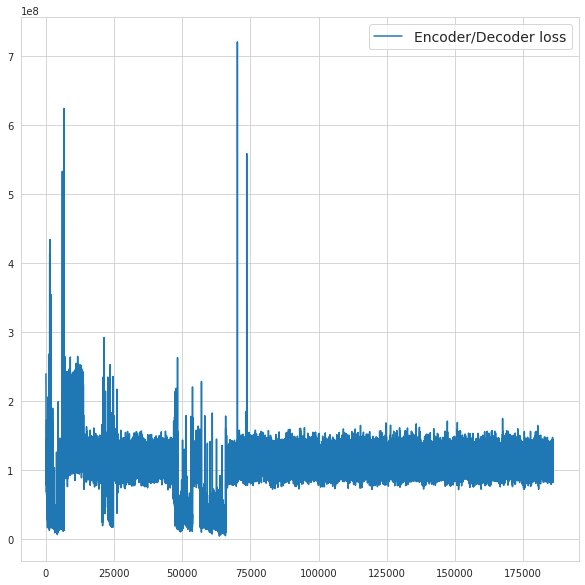

In [ ]:
# Plotting ED loss:

plt.figure(figsize=(10,10))

plt.plot(ed_hist, label="Encoder/Decoder loss")
plt.legend(fontsize=14)

plt.show()

In [ ]:
# This shows some periodic behavior, possibly due to our cyclic learning rate. How to adjust?

In [ ]:
# A test of the trained decoder(encoder):

ex_sent = new_train_sents_english[10543]
sentence = ""
for word_index in ex_sent:
  sentence = sentence + " " + Pro_Lyrics_corpus_english[word_index]
print(ex_sent)
print(sentence)

# note: we have to make this floats and pad with floats.
ex_sent = list(np.array(ex_sent).astype(float))

ex_sent = ex_sent + [31489.0, 31489.0, 31489.0, 31489.0, 31489.0]
ex_sent = tf.expand_dims(ex_sent, axis = -1)
ex_sent = tf.expand_dims(ex_sent, axis = 0) 

test_output2 = decoder(encoder(ex_sent))

# Resizing:
test_output2 = 0.5*(test_output2 + 1) * len(Pro_Lyrics_corpus_english)

print(test_output2)
print()
print(rectifier(test_output2, len(Pro_Lyrics_corpus_english)))
print()
result = decode_and_print(rectifier(test_output2, len(Pro_Lyrics_corpus_english)), Pro_Lyrics_corpus_english)
print(result)

[1074, 882, 1908, 542]
 there thing forever son
tf.Tensor(
[[[19394.195]
  [18613.062]
  [21675.188]
  [25518.541]
  [28844.098]
  [30397.84 ]
  [31031.652]
  [31299.35 ]]], shape=(1, 8, 1), dtype=float32)

[[[19394]
  [18613]
  [21675]
  [25519]
  [28844]
  [30398]
  [31032]
  [31299]]]

tec catalysis discriminating subcity paroxysm berri translocation ceratoid 


# **Saving Encoder/Decoder Models**

In [ ]:
# SAVE the encoder and decoder model here:

encoder.save('/content/drive/MyDrive/NLP bootcamp project/models/encoder.h5')
decoder.save('/content/drive/MyDrive/NLP bootcamp project/models/decoder.h5')


# **WGAN Training - Loading Encoder and Decoder**

In [ ]:
# LOAD the encoder/decoder here:

encoder = tf.keras.models.load_model('/content/drive/MyDrive/NLP bootcamp project/models/encoder.h5')
decoder = tf.keras.models.load_model('/content/drive/MyDrive/NLP bootcamp project/models/decoder.h5')


In [ ]:
encoder.compile()
decoder.compile()

# **WGAN Training Loops**

In [ ]:
@tf.function
def d_train_step(batch):
    noise = tf.random.normal([len(batch), noise_dim])

    with tf.GradientTape() as disc1_tape:
        generated_batch = generator(noise, training=True)

        # No need to resize, encoder uses tanh activation and is trained without resizing:
        #generated_batch = 0.5*(generated_batch + 1) * len(Pro_Lyrics_corpus)

        encoded_batch = encoder(batch)
        encoded_batch = tf.expand_dims(encoded_batch, axis = -1)
        
        real_output1 = discriminator1(encoded_batch, training=True)
        fake_output1 = discriminator1(generated_batch, training=True)

        # do we want shape [BATCH_SIZE, 100, 1] or [BATCH_SIZE, 1, 1]???
        epsilon = tf.random.normal([len(batch), 1, 1], 0.0, 1.0)
        # We need the gradient penalty to happen at the encoded level:
        gp = gradient_penalty(encoded_batch, generated_batch, epsilon)

        disc1_loss = discriminator_loss_total(real_output1, fake_output1, gp)

        disc1_loss_r = discriminator_loss_real(real_output1)
        disc1_loss_f = discriminator_loss_fake(fake_output1)



    gradients_of_discriminator1 = disc1_tape.gradient(disc1_loss, discriminator1.trainable_variables)

    discriminator_optimizer1.apply_gradients(zip(gradients_of_discriminator1, discriminator1.trainable_variables))


    return disc1_loss, disc1_loss_r, disc1_loss_f

In [ ]:
@tf.function
def g_train_step():
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape:
        generated_images = generator(noise, training=True)

        # No need to resize, encoder uses tanh activation and is trained without resizing:
        #generated_images = 0.5*(generated_images + 1) * len(Pro_Lyrics_corpus)

        fake_output1 = discriminator1(generated_images, training=True)

        gen_loss = generator_loss(fake_output1)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    return gen_loss

In [ ]:
# This trains the discriminator and generator:

def train(dataset, epochs):
    n_critic = 5
    c_hist, c_r_hist, c_f_hist, g_hist = list(), list(), list(), list()
    # Should the noise go here??? And pass the same noise to the d_train_step and g_train_step???
    count = 0

    for epoch in range(epochs):
        start = time.time()

        for batch in dataset:
            c_tmp, c_r_tmp, c_f_tmp, g_tmp = list(), list(), list(), list()

            for _ in range(n_critic):
                c_loss, c_r_loss, c_f_loss = d_train_step(batch)
                c_tmp.append(c_loss)
                c_r_tmp.append(c_r_loss)
                c_f_tmp.append(c_f_loss)

            c_hist.append(mean(c_tmp))
            c_r_hist.append(mean(c_r_tmp))
            c_f_hist.append(mean(c_f_tmp))

            g_loss = g_train_step()
            g_hist.append(g_loss)

            if count%1000 == 0:
              print('>%d, c1=%.3f, c1r=%.3f, c1f=%.3f, g=%.3f' % (count+1, c_hist[-1], c_r_hist[-1], c_f_hist[-1], g_loss))

            count += 1

        # Print a generated song line every epoch:
        #display.clear_output(wait=True)
        if (epoch + 1) % 1 == 0:
          generate_and_save(generator, epoch + 1, seed)

        # Save the model every 5 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))


    # Generate after the final epoch
    #display.clear_output(wait=True)
    generate_and_save(generator, epochs, seed)

    return c_hist, c_r_hist, c_f_hist, g_hist

In [ ]:
def generate_and_save(model, epoch, test_input):
    # Notice 'training' is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    for i in range(predictions.shape[0]):
        prediction = tf.expand_dims(predictions[i,:,0], axis = 0)
        decoded_sent = decoder(prediction)

        # Resizing:
        decoded_sent = 0.5*(decoded_sent + 1) * len(Pro_Lyrics_corpus_english)

        sentence = decode_and_print(rectifier(decoded_sent, len(Pro_Lyrics_corpus_english)), Pro_Lyrics_corpus_english)
        print(sentence)
        print()


          # Save the sentences/lines here?

# **Instantiating WGAN Models, Initial Tests**

In [ ]:
# the 3 fields for the generator are: 
# (L2 regularization parameter for the kernel, T/F value of whether to use kernel constraint, MaxNorm value for the kernel
# constraint [if included using the T/F value]).

# Here we make the generator and apply it to sample noise:
generator = make_generator_model(0.0001)
noise = tf.random.normal([1, 100])
S = generator(noise, training=False)

#plt.imshow(S[0, :, 0], cmap='gray')

In [ ]:
S.shape

TensorShape([1, 100, 1])

In [ ]:
decoded_S = 0.5*(decoder(S[:,:,0]) + 1) * len(Pro_Lyrics_corpus_english)
decoded_S.shape


TensorShape([1, 8, 1])

In [ ]:
# Now apply the rectifier to make all entries 0 or 1:
newS = rectifier(decoded_S[0,:,0], len(Pro_Lyrics_corpus_english))
#newS
test_sent = decode_and_print(newS, Pro_Lyrics_corpus_english)
print(test_sent)

undignified lanner accost lightlessness katabasis unminding joylessly sorrowfully 


In [ ]:
# Just checking what a real song line looks like (6th line in our data):
#plt.imshow(train_sents[5][:maxlen], cmap='gray')

In [ ]:
# the 4 fields for the discriminators are: 
# (L2 regularization parameter for the kernel, T/F value of whether to use a kernel constraint, MaxNorm value for the kernel
# constraint [if included using the T/F value], and dropout rate).

discriminator1 = make_discriminator_model1(0.0001, 0.3)   # Dropout was 0.3 earlier
#discriminator2 = make_discriminator_model2(0.0001, 0.3)
#discriminator3 = make_discriminator_model3(0.0001, 0.3)
decision1 = discriminator1(S)
#decision2 = discriminator2(newS)
#decision3 = discriminator3(newS)
print(np.array(decision1)[0][0])  #, np.array(decision2)[0][0], np.array(decision3)[0][0])
print()
# positive for real, negative for fake.

# weighted sum of 3 decisions:
#weight1 = 1
#weight2 = 1.5
#weight3 = 0.7
#print((weight1*np.array(decision1)[0][0] + weight2*np.array(decision2)[0][0] + weight3*np.array(decision3)[0][0])/(weight1+weight2+weight3))

-7.9190364e-08



# **WGAN Learning Rate Scheduling and Optimizers**

In [ ]:
# Try a learning rate schedule (exponential decreasing cyclic)

#initial_learning_rate = 0.1
#lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, 
                                                          #decay_steps=100000, 
                                                          #decay_rate=0.96, 
                                                          #staircase=True)

lr_schedule2 = tfa.optimizers.ExponentialCyclicalLearningRate(initial_learning_rate=1e-4,
                                                             maximal_learning_rate=1e-3,
                                                             step_size=2000,
                                                             scale_mode="cycle",
                                                             gamma=0.95,
                                                             name="MyCyclicScheduler")

generator_optimizer = RMSprop(learning_rate=lr_schedule2)
discriminator_optimizer1 = RMSprop(learning_rate=lr_schedule2)
#discriminator_optimizer2 = RMSprop(learning_rate=lr_schedule2)
#discriminator_optimizer3 = RMSprop(learning_rate=lr_schedule2)

import os
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer1=discriminator_optimizer1,
                                 generator=generator,
                                 discriminator1=discriminator1)
                                 #discriminator2=discriminator2,
                                 #discriminator3=discriminator3)

# **WGAN Training**

In [ ]:
# Now for actual training:

c_hist,c_r_hist,c_f_hist,g_hist = train(train_dataset, EPOCHS)



>1, c1=9.998, c1r=0.000, c1f=-0.000, g=0.000
>1001, c1=8.435, c1r=-4.825, c1f=5.176, g=-5.154
>2001, c1=7.445, c1r=-8.734, c1f=9.407, g=-9.355
>3001, c1=7.385, c1r=-8.439, c1f=9.228, g=-8.760
>4001, c1=6.414, c1r=-2.460, c1f=3.244, g=-3.820
>5001, c1=7.030, c1r=-9.690, c1f=11.229, g=-10.865
>6001, c1=5.832, c1r=-13.957, c1f=14.692, g=-14.618
>7001, c1=5.838, c1r=-8.027, c1f=9.066, g=-9.454
>8001, c1=5.760, c1r=-3.901, c1f=4.990, g=-4.703
rumple unworked augmented untriumphant acquittal pap adjuster stent 

kras vicarious oligarchy cannoneer hemophilia betterness whiteworm bogard 

tec unoxidized needham restain arrastre agla unsight hermeneutic 

tec stringent turnback statured flophouse whitish humorous recto 

Time for epoch 1 is 397.9786615371704 sec
>9001, c1=6.021, c1r=-6.432, c1f=8.054, g=-7.935
>10001, c1=5.587, c1r=-9.550, c1f=11.341, g=-11.650
>11001, c1=5.128, c1r=-2.555, c1f=3.579, g=-4.189
>12001, c1=5.290, c1r=-2.557, c1f=4.305, g=-4.775
>13001, c1=5.901, c1r=-2.496, c1f=4

# **Losses and Testing**

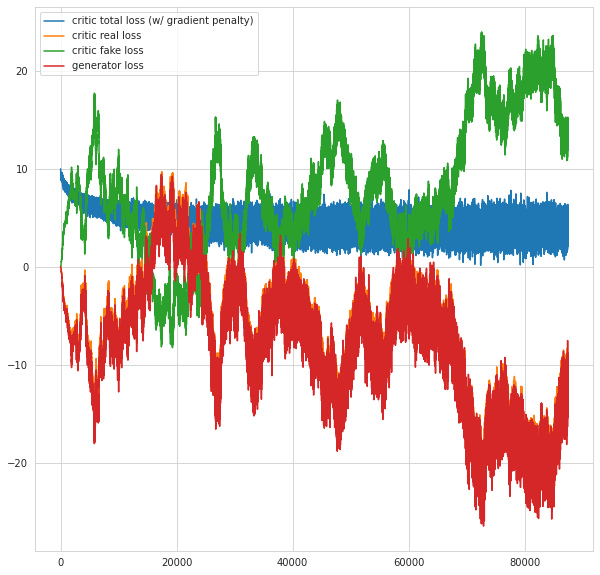

In [ ]:
plt.figure(figsize = (10,10))

plt.plot(c_hist, label="critic total loss (w/ gradient penalty)")
plt.plot(c_r_hist, label="critic real loss")
plt.plot(c_f_hist, label="critic fake loss")
plt.plot(g_hist, label="generator loss")

plt.legend()

plt.show()

# **Saving WGAN Model**

In [ ]:
# SAVE the generator/discriminator here:

generator.save('/content/drive/MyDrive/NLP bootcamp project/models/generator.h5')
discriminator1.save('/content/drive/MyDrive/NLP bootcamp project/models/discriminator1.h5')


In [ ]:
# Things to do/fix:

#1. [[Add gradient penalty to discriminator training]]
#       DONE! is epsilon correct?

#2. [[Play with the cyclic part of both learning rates, maybe make the range from trough to crest less]]
#       DONE! check performance though

#3. [[Change cross-entropy loss for encoder/decoder to MSE?]]
#       DONE! check performance though

#4. [[Add one more LSTM layer to both encoder/decoder?]] Make them RNNs?
#       DONE! check performance/whether it works though

#5. Should we have (relu) activations? Makes the kernel not compute using cuDNN, which is faster.
#       Make it tanh activations but do 0.5(tanh(x) + 1) to get a probability in (0,1), THEN multiply by len(corpus)!
#       Do all of this during training step.

#6. IDEA: change architecture so outputs of decoder are probabilities? softmax? How to save order of sentence though?

#7. Investigate the need for the rectifier..I thought encoder/decoder would get rid of that need?

